# Fully Connected vs. Convolutional Neural Networks

## Refs 

https://www.tensorflow.org/install

https://www.tensorflow.org/tutorials/keras/classification
    

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo
# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

import numpy as np
import matplotlib.pyplot as plt
import time

# Auxiliary functions

In [2]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)


def show_histories():

    # summarize history for accuracy
    plt.plot(history_IV['accuracy'])
    plt.plot(history_C['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['model FC', 'model Conv'], loc='lower right')
    plt.show()


def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(4)

    models = ['model 1', 'model 2', 'model 3', 'model 4']
    plt.bar(X, eval_acc, width = 0.4, color = 'b', label='eval')
    plt.bar(X + 0.4, train_acc, color = 'r', width = 0.4, label = "train")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom =95)
    plt.legend(loc='lower right')
    plt.show()    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model_IV(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds)        

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

epochs = 3

cuda:0


## Load MNIST dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

batch_size = 128

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False)

## Display a few images

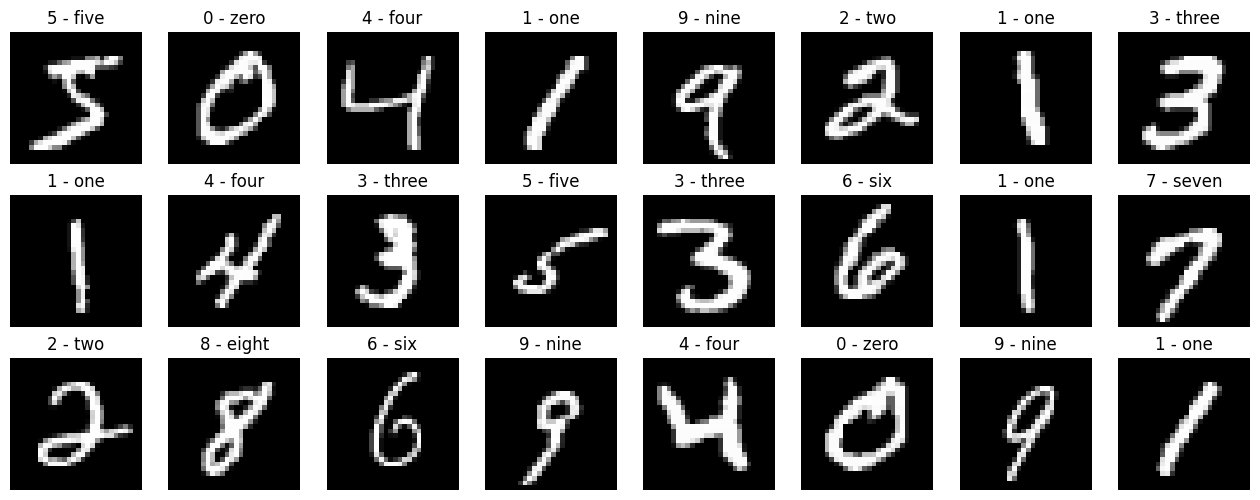

<Figure size 640x480 with 0 Axes>

In [5]:
images, targets = next(iter(train_loader))

# these are the transformed images
vcpi_util.show_transformed_images(3,8, train_set, train_set.classes) 

# Build and train a fully connected model

In [6]:
class FullyConnected_IV(torch.nn.Module):

    def __init__(self,num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256,128)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(128,64)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(64,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)

        return(x)

In [7]:
model_IV = FullyConnected_IV(len(train_set.classes))
model_IV.to(device)
print(model_IV)

torchinfo.summary(model_IV, input_size=(batch_size, 1, 28, 28))

FullyConnected_IV(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_IV                        [128, 10]                 --
├─Linear: 1-1                            [128, 256]                200,960
├─ReLU: 1-2                              [128, 256]                --
├─Linear: 1-3                            [128, 128]                32,896
├─ReLU: 1-4                              [128, 128]                --
├─Linear: 1-5                            [128, 64]                 8,256
├─ReLU: 1-6                              [128, 64]                 --
├─Linear: 1-7                            [128, 10]                 650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 31.07
Input size (MB): 0.40
Forward/backward pass size (MB): 0.47
Params size (MB): 0.97
Estimated Total Size (MB): 1.84

## Load model

In [10]:
optimizer_IV = torch.optim.Adam(model_IV.parameters())

retrieved = torch.load(f'model_IV_50.pt')
    
model_IV.load_state_dict(retrieved['model'])
model_IV.to(device)

optimizer_IV.load_state_dict(retrieved['optimizer'])
history_IV = retrieved['history']


## Evaluate Model

In [12]:
evaluate(model_IV, test_loader)


0.9817000031471252

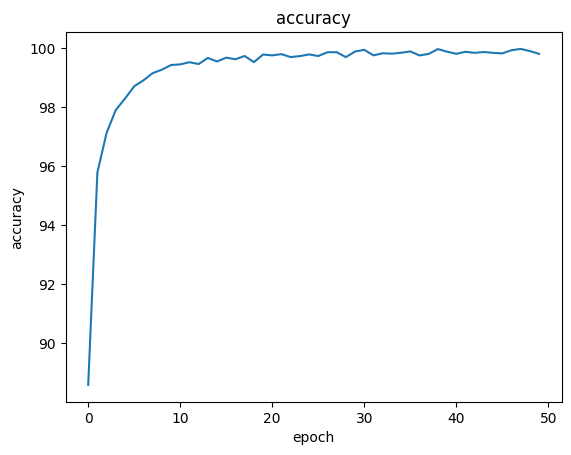

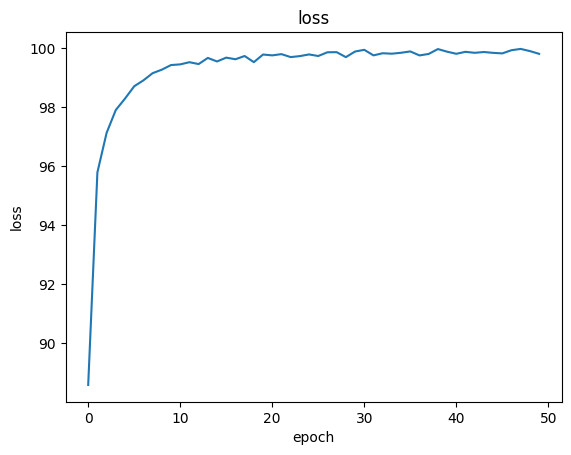

In [13]:
vcpi_util.show_history(history_IV)

# Build and train a Convolutional Model

## Defining a convolution layer

The geometry of a 2D convolutional can be defined with the following elements:

- kernel (int or tuple): the size of the convolving kernel
- stride (int or tuple): how many pixels to advance for each convolution, default: 1
- padding (int, tupple, str): how many pixels to add to each side of the input image, default: 0

Padding and stride are relevant for the size of the output image.

In [11]:

input = torch.randn(16, 1, 32, 32)
c = torch.nn.Conv2d(1,1,3,padding = 1, stride = 2)
output = c(input)

print(input.shape, output.shape)

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 16, 16])


### Understanding the output shape of the convolutional layers

For a model training with MNIST, The input of the first convolutional layer is a single channel image with dimension 28 x 28. Since no padding was specified, the default value 'valid' is used. This implies that the kernel is not applied at the borders of the image. Using a 3 x 3 filter means that the filter is not applied to the top and bottom rows, as well as left and right columns, resulting in an image with less 2 columns and less two rows, i.e. 26 x 26.

If a 5 x 5 filter was used then the output would be 24 x 24.

On the other hand, setting padding = 'same' would keep the original dimensions


### Counting the number of weights

The first convolutional layer has 16 filters, with 3x3 kernels. The input is a single channel image.

- number of parameters = number of weights + number of biases

- number of weights = number of input channels x number of filters x filter width x filter height = 1 x 16 x 3 x 3 = 144

- number of biases = number of filters (one bias per filter) = 16

- number of parameters = 144 + 16 = 160

The second convolutional layer has an input with 16 channels (the output from each of the filters from the previous convolutional layer)

- number of weights = number of input channels x number of filters x filter width x filter height = 16 * 16 * 3 * 3 = 2304

- number of biases = number of filters = 16

- number of parameters = 2304 + 16 = 2302

The first dense layer receives a flattened input from the last convolution layer with dimension = 24 x 24 x 16 = 9216 parameters.

This layer has 32 units, so the total number of parameters = 9216 x 32 + 32 = 294944

Considering the second dense layer, it has an input of 32 values and contains 10 units, hence, the number of parameters is = 32 x 10 + 10 = 330

#### Two notes:

- the bulk of the training parameters comes from the dense layers

- the number of parameters of a convolutional layer does not depend on the input image width or height. It only depends on the number of channels and kernel size.



### Counting the number of multiplications and Additions

In a dense layer with $n$ input units and $m$ output units, the number of operations is:

- multiplications: $n \times m$
- additions: $(n-1) \times m$ 

Note that the number od multiplications matches the number of weights connecting the layer to its input, as there is a multiplication per weight.

In a convolutional layer the number of operations is dependent on the dimension of the output, which determines the number of convolutions applied per input channel, and the number of filters. Hence,

- total number of convolutions is $h \times w \times channels \times filters$

where $h$ and $w$ are the hight and width of the input.

Per convolution the number of operations is dependent on the dimension of the kernel. For a kernel $kw \times kh$, the number of operations is:

- multiplications: $kw \times kh$
- additions: $kw \times kh - 1$ 

Considering the first convolution layer, the number of input channels is $1$, the output's dimensions is $26 \times 26$, the number of filters is $16$, hence, the number of convolutions is:

- convs = $26 \times 26 \times\ 1 \times 16 = 10816$

The kernel is $3 \times 3$, therefore, there are $9$ multiplications and 8 additions per convolution. 

The total number of operations is:

- multiplications: $10816 \times 9 = 97377 $
- additions: $10816 \times 8 = 86528$

Notes:

- The number of operations in a convolutional layer can be quite large, even when the number of weights is rather small. In the first hidden layer we had only 160 weights, but almost 100.000 multiplications.

## Building the model

In [12]:
class Conv(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.relu4 = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(19200, 10)
        

    def forward(self, x):    
        
        # input = (bs, 1, 28,28)
        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.relu2(x)
        x = self.conv3(x) # -> (bs, 48, 22, 22)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 20, 20)
        x = self.relu4(x)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 20 * 20 = 1920)
        x = self.fc1(x)        # -> (bs, 10)

        return(x)


model_Conv = Conv()
model_Conv.to(device)
print(model_Conv)

torchinfo.summary(model_Conv, input_size=(batch_size, 1, 28, 28))

Conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=19200, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─ReLU: 1-2                              [128, 16, 26, 26]         --
├─Conv2d: 1-3                            [128, 32, 24, 24]         4,640
├─ReLU: 1-4                              [128, 32, 24, 24]         --
├─Conv2d: 1-5                            [128, 48, 22, 22]         13,872
├─ReLU: 1-6                              [128, 48, 22, 22]         --
├─Conv2d: 1-7                            [128, 48, 20, 20]         20,784
├─ReLU: 1-8                              [128, 48, 20, 20]         --
├─Linear: 1-9                            [128, 10]                 192,010
Total params: 231,466
Trainable params: 231,466
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.30
Input size (MB): 0.40
Forward/backward pass size (MB): 73.41
Params size (MB): 0.93
Estimated To

## Train the model

In [13]:
optimizer_C = torch.optim.Adam(model_Conv.parameters())

history_C = train(model_Conv, train_loader, epochs, loss_fn, optimizer_C)
train_acc.append(history_C['accuracy'][-1])

Epoch: 000; Accuracy = 94.4717; Elapsed time: 7.0983
Epoch: 001; Accuracy = 98.3750; Elapsed time: 6.5756
Epoch: 002; Accuracy = 98.8967; Elapsed time: 6.5428
Finished Training


## Evaluate the model

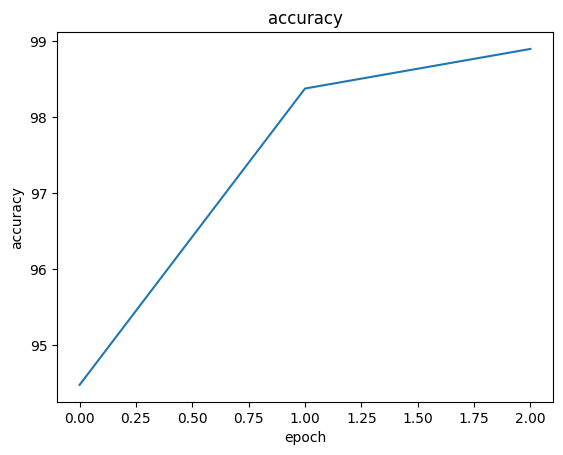

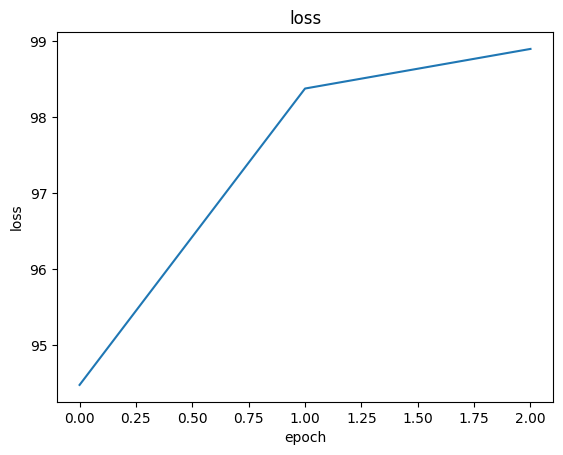

In [14]:
vcpi_util.show_history(history_C)

In [15]:
eval_acc.append(evaluate(model_Conv, test_loader))
print(eval_acc[-1])

0.9866999983787537


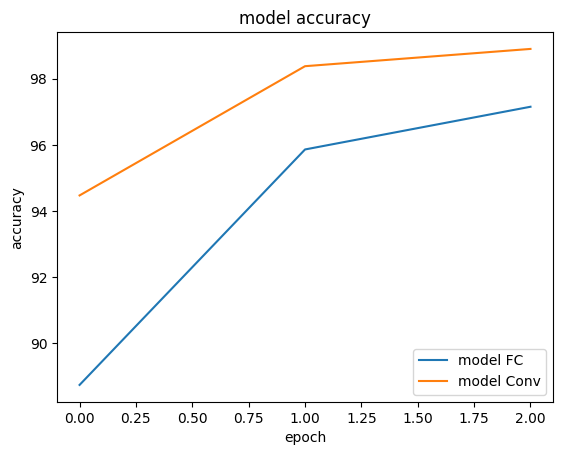

In [16]:
show_histories()

# Visualizing the convolution layers

### First we check the layers in the model

In [17]:
for name, module in model_Conv.named_children():
    print (name, module)

conv1 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
relu1 ReLU()
conv2 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
relu2 ReLU()
conv3 Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
relu3 ReLU()
conv4 Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
relu4 ReLU()
fc1 Linear(in_features=19200, out_features=10, bias=True)


## Build a list with all conv layers

In [18]:
conv_modules = [(name,module) for name, module in model_Conv.named_children() if module._get_name() == 'Conv2d']

for name, m in conv_modules:
    print(name, 'in: ', m.in_channels, ' out: ', m.out_channels, ' stride: ', m.stride, ' padding = ', m.padding)



conv1 in:  1  out:  16  stride:  (1, 1)  padding =  (0, 0)
conv2 in:  16  out:  32  stride:  (1, 1)  padding =  (0, 0)
conv3 in:  32  out:  48  stride:  (1, 1)  padding =  (0, 0)
conv4 in:  48  out:  48  stride:  (1, 1)  padding =  (0, 0)


## Show the layer feature maps

In [21]:
activation = {}

def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [22]:
hooks = [m.register_forward_hook(getActivation(n)) for n,m in conv_modules]

image, _ = next(iter(train_loader))
image = image.to(device)

out = model_Conv(image[0].unsqueeze(dim=0))

print(activation['conv1'].shape)

torch.Size([1, 16, 26, 26])


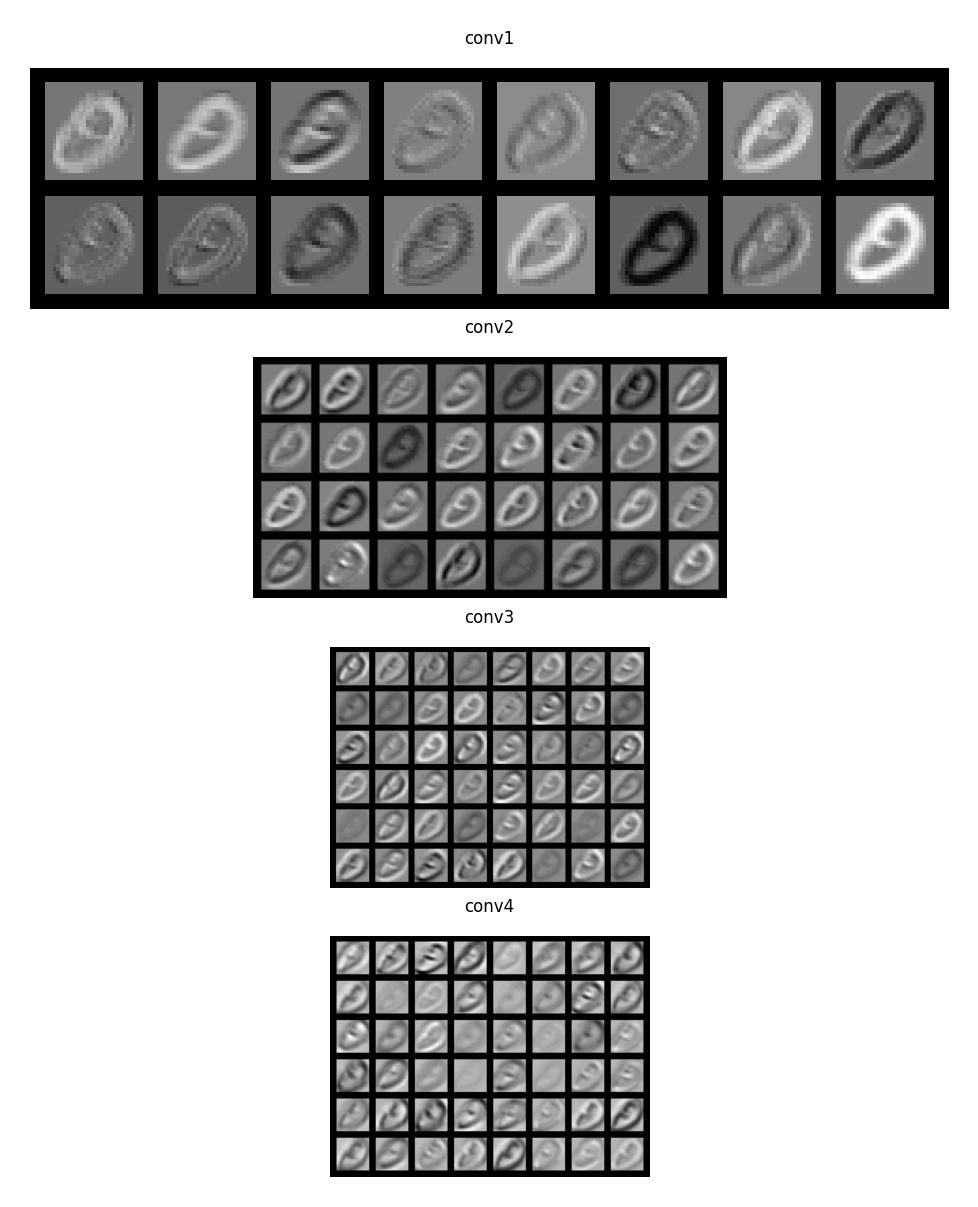

In [23]:
f, axarr = plt.subplots(len(activation)) 
f.set_dpi(300)

for i, act in enumerate(activation):

    filter_img = torchvision.utils.make_grid(activation[act].cpu().permute(1,0,2,3), nrow = 8, normalize=True, padding = 4)
    axarr[i].set_axis_off()
    axarr[i].imshow(filter_img.permute(1,2,0), cmap='gray') 
    axarr[i].set_title(act, fontsize = 4)


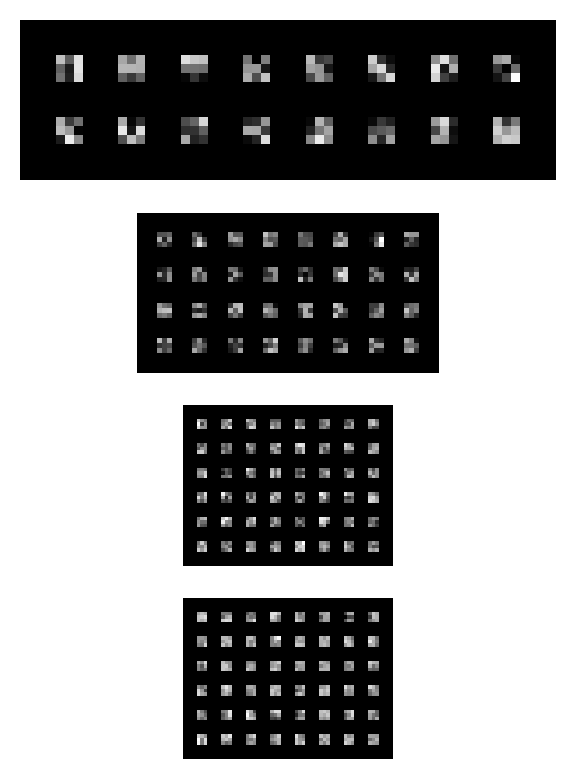

In [24]:
f, axarr = plt.subplots(len(conv_modules),1) 
f.set_dpi(200)

count = 0
for i, (_,m) in enumerate(conv_modules):

    kernels = m.weight.detach().cpu().clone()

    
    k_view = kernels[:,0,:,:]
    #print(k_view.shape)
    k_view = k_view.unsqueeze(dim=1)
    #print(k_view.shape)

    k_view = (k_view - k_view.min()) / (k_view.max() - k_view.min()) 
    
    filter_img = torchvision.utils.make_grid(k_view, nrow = 8, normalize=True, padding = 4)
    # torch uses channels first: permute 1,3,3 -> 3,3,1
    #axarr[count].set_title(f'Conv {i}')
    axarr[count].set_axis_off()
    axarr[count].imshow(filter_img.permute(1, 2, 0)) 
    count += 1



